## give me some credit
### 数据初探

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [2]:
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')
combined = pd.concat([train, test], axis=0, ignore_index=True)

In [3]:
combined.shape

(251503, 12)

字段含义：
- SeriousDlqin2yrs：逾期90天及以上标识，y/n
- RevolvingUtilizationOfUnsecuredLines：除按揭房贷外，信用卡和个人信贷余额除以信用额度之和，0-1
- age：年龄
- NumberOfTime30-59DaysPastDueNotWorse：2年内，逾期30-59天的次数
- DebtRatio：负债率，每月债务支付，赡养费，生活费用除以月总收入
- MonthlyIncome：每月收入
- NumberOfOpenCreditLinesAndLoans：按揭贷款和额度
- NumberOfTimes90DaysLate：逾期90天次数
- NumberRealEstateLoansOrLines：抵押贷款和信用卡数
- NumberOfTime60-89DaysPastDueNotWorse：2年内，逾期60-89天的次数
- NumberOfDependents：家庭成员数

## 特征
> 
- 新特征 UnknownNumberOfDependents：NumberOfDependents为空设置为1，非空为0
- 新特征 UnknownMonthlyIncome：MonthlyIncome为空设置为1，非空为0
- 新特征 NoDependents：无家庭成员，NumberOfDependents为0则设置为1，非0为0，空值为0
- 缺失值填补 NumberOfDependents：空值设为0
- 新特征 NoIncome：MonthlyIncome为0设置为1，非0为0，NoIncome空值设置为0
- 缺失值填补 MonthlyIncome：MonthlyIncome为空设为0
- 新特征 ZeroDebtRatio：DebtRatio为0设置为1，否则为0
- 新特征 UnknownIncomeDebtRatio：UnknownMonthlyIncome（即MonthlyIncome不为空）为0设为0，UnknownMonthlyIncome为1则取DebtRatio，**有疑惑**
- 缺失值填补 DebtRatio：UnknownMonthlyIncome为1（即MonthlyIncome为空）设为0，**有疑惑**
- 新特征 WeirdRevolvingUtilization：先将RevolvingUtilizationOfUnsecuredLines赋值给新特征，然后对于log(RevolvingUtilizationOfUnsecuredLines) <= 3的赋值为0
- 新特征 ZeroRevolvingUtilization：RevolvingUtilizationOfUnsecuredLines为0设为1，否则为0
- 值修改 RevolvingUtilizationOfUnsecuredLines：log(RevolvingUtilizationOfUnsecuredLines)>3的修改值为0
- 新特征Log.Debt：首先对于每条MonthlyIncome与1对比，选择较大的值后，与DebtRatio相乘再取log值，对于其中的inf值设置为0
- 新特征 RevolvingLines：NumberOfOpenCreditLinesAndLoans - NumberRealEstateLoansOrLines
- 新特征 HasRevolvingLines：RevolvingLines大于0设为1，否则为0
- 新特征 HasRealEstateLoans：NumberRealEstateLoansOrLines大于0设为1，否则为0
- 新特征 HasMultipleRealEstateLoans：NumberRealEstateLoansOrLines大于2设为1，否则为0
- 新特征 EligibleSS：age大于等于60设为1，否则为0
- 新特征 DTIOver33：NoIncome为0且DebtRatio大于0.33
- 新特征 DTIOver43：NoIncome为0且DebtRatio大于0.43
- 新特征 DisposableIncome：（1-DebtRatio）\* MonthlyIncome，NoIncome为1的设置为0
- 新特征 RevolvingToRealEstate：RevolvingLines / （1+NumberRealEstateLoansOrLines）
- 新特征 NumberOfTime30.59DaysPastDueNotWorseLarge：NumberOfTime30.59DaysPastDueNotWorse大于90设置为1，否则为0
- 新特征 NumberOfTime30.59DaysPastDueNotWorse96：NumberOfTime30.59DaysPastDueNotWorse为96设为1，否则为0
- 新特征 NumberOfTime30.59DaysPastDueNotWorse98：NumberOfTime30.59DaysPastDueNotWorse为98设为1，否则为0
- 新特征 Never30.59DaysPastDueNotWorse：NumberOfTime30.59DaysPastDueNotWorse为0则设为1
- 值修改 NumberOfTime30.59DaysPastDueNotWorse：大于90的值修改为0
- 新特征 NumberOfTime60.89DaysPastDueNotWorseLarge： NumberOfTime60.89DaysPastDueNotWorse大于90设为1，否则为0
- 新特征 NumberOfTime60.89DaysPastDueNotWorse96：NumberOfTime60.89DaysPastDueNotWorse为96设为1，否则为0
- 新特征 NumberOfTime60.89DaysPastDueNotWorse98：NumberOfTime60.89DaysPastDueNotWorse为98设为1，否则为0
- 新特征 Never60.89DaysPastDueNotWorse：NumberOfTime60.89DaysPastDueNotWorse为0设为1，否则为0
- 值修改 NumberOfTime60.89DaysPastDueNotWorse：大于90的值修改为0
- 新特征 NumberOfTimes90DaysLateLarge：NumberOfTimes90DaysLate大于90设为1，否则为0

...

In [4]:
train.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

## 数据基本情况
- 看下每个变量的取值情况，结合含义判断取值是否合理，是否可以定义为离群点，并对异常值进行处理

In [5]:
def delect_outliers(df, n, columns):
    outliers_index = []
    for c in columns:
        q1 = np.percentile(df[c], 25)
        q3 = np.percentile(df[c], 75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr
        
        outliers = df[(df[c]<q1-outlier_step) | (df[c]>q3+outlier_step)].index
        outliers_index.extend(outliers)
    delete_target = Counter(outliers_index)
    indexes = [i for i, v in delete_target.items() if v > n]
    return indexes

In [16]:
def show_count_ratio(data, x, y, xsize, ysize, ylim=1):
    fig = plt.figure(figsize=(xsize, ysize))
    ax = fig.add_subplot(111)
    ax.set_xticklabels(data[x].values, rotation=45)
    ax2 = ax.twinx()
    a1 = sns.countplot(data=data, x=x, ax=ax, palette='colorblind', alpha=0.7)
    a2 = sns.pointplot(data=data, x=x, y=y, ci=None, scale=0.8, ax=ax2, alpha=0.8)
    ax2.set_ylim((0, ylim))
    ax.legend(['count'],loc=(.75,.90), fontsize=15)
    ax2.legend(['ratio'],loc=(.75, .85), fontsize=15)
    
    ax.grid(False)
    ax2.grid(False)
    plt.show()

### RevolvingUtilizationOfUnsecuredLines
- 取值范围0-1，将小于0的置为0，大于1的置为1

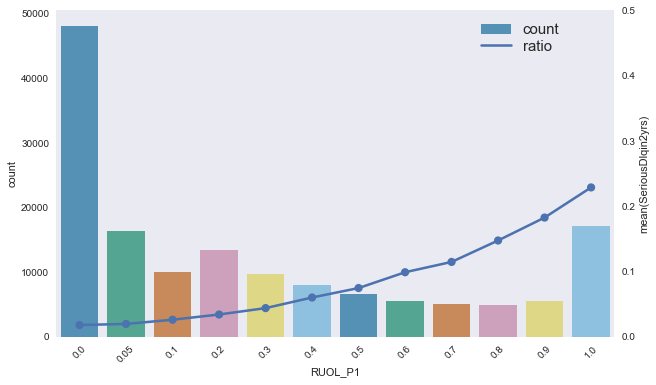

In [17]:
def change_feature_1(x, precision):
    if x < 0.05:
        return 0
    elif x >= 0.05 and x < 0.1:
        return 0.05
    elif x > 1:
        return 1
    else:
        return np.round(x, precision)
    
combined.loc[:, 'RUOL_P1'] = combined['RevolvingUtilizationOfUnsecuredLines'].apply(change_feature_1, args=(1,))
show_count_ratio(combined[:train.shape[0]], 'RUOL_P1', 'SeriousDlqin2yrs', 10, 6, 0.5)

- 可以看出，这个变量还是具有较为明显的趋势，总额度使用率越高，逾期可能性越大

### age
- 看下年龄是否有异常的值

In [18]:
combined['age'].describe()

count    251503.000000
mean         52.339694
std          14.775120
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

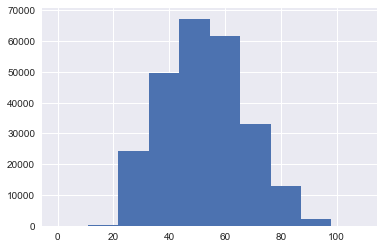

In [19]:
combined['age'].hist()

In [20]:
def change_age(x):
    if x < 18:
        return 18
    elif x > 90:
        return 90
    else:
        return x
    
combined.loc[:, 'ageNew'] = combined['age'].map(change_age)

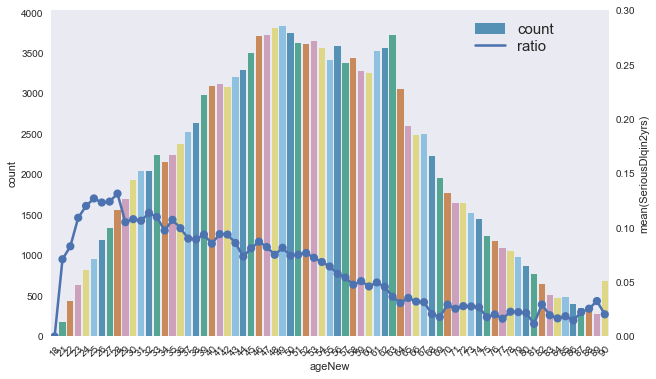

In [22]:
show_count_ratio(combined[:train.shape[0]], 'ageNew', 'SeriousDlqin2yrs', 10, 6, 0.3)

- 看起来没有很明显的趋势，仔细看年龄越大，逾期可能性越小，再进行一下切分看看效果

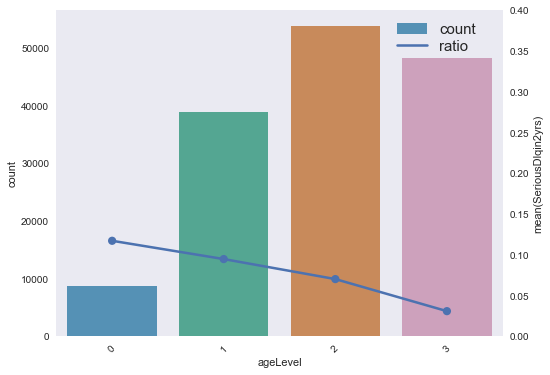

In [25]:
def age_level(x):
    if x < 30:
        return 0
    elif x >= 30 and x< 45:
        return 1
    elif x >= 45 and x< 60:
        return 2
    else:
        return 3
    
combined['ageLevel'] = combined['ageNew'].map(age_level)
show_count_ratio(combined[:train.shape[0]], 'ageLevel', 'SeriousDlqin2yrs', 8, 6, 0.4)

- 年龄暂时先这样

### NumberOfTime30-59DaysPastDueNotWorse & NumberOfTime60-89DaysPastDueNotWorse

In [29]:
combined['NumberOfTime30-59DaysPastDueNotWorse'].isnull().sum()

0

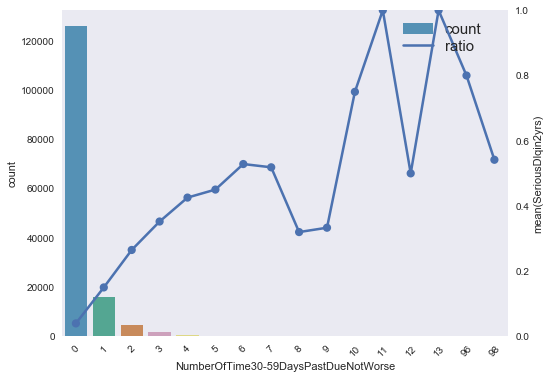

In [28]:
show_count_ratio(combined[:train.shape[0]], 'NumberOfTime30-59DaysPastDueNotWorse', 'SeriousDlqin2yrs', 8, 6, 1.0)

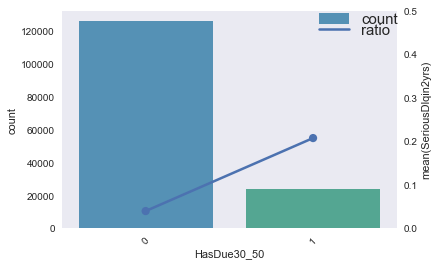

In [33]:
combined['HasDue30_50'] = combined['NumberOfTime30-59DaysPastDueNotWorse'].map(lambda x: 0 if x == 0 else 1)
show_count_ratio(combined[:train.shape[0]], 'HasDue30_50', 'SeriousDlqin2yrs', 6, 4, 0.5)

In [34]:
combined['NumberOfTime60-89DaysPastDueNotWorse'].isnull().sum()

0

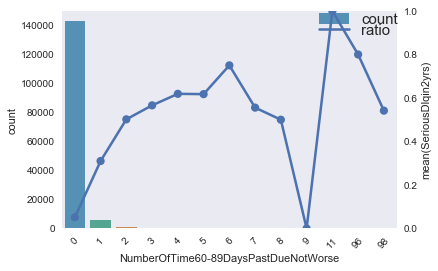

In [35]:
show_count_ratio(combined[:train.shape[0]], 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs', 6, 4, 1.0)

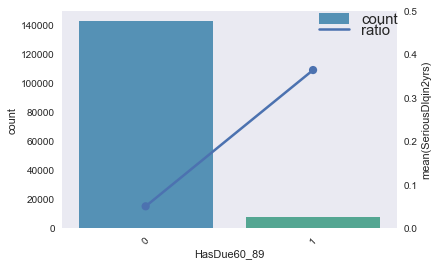

In [37]:
combined['HasDue60_89'] = combined['NumberOfTime60-89DaysPastDueNotWorse'].map(lambda x: 0 if x == 0 else 1)
show_count_ratio(combined[:train.shape[0]], 'HasDue60_89', 'SeriousDlqin2yrs', 6, 4, 0.5)

### DebtRatio

In [39]:
combined['DebtRatio'].describe()

count    251503.000000
mean        349.562468
std        1884.792016
min           0.000000
25%           0.174330
50%           0.365612
75%           0.861754
max      329664.000000
Name: DebtRatio, dtype: float64

- 按理说DebtRatio应该是0-1的值，看下大于1的值的占比

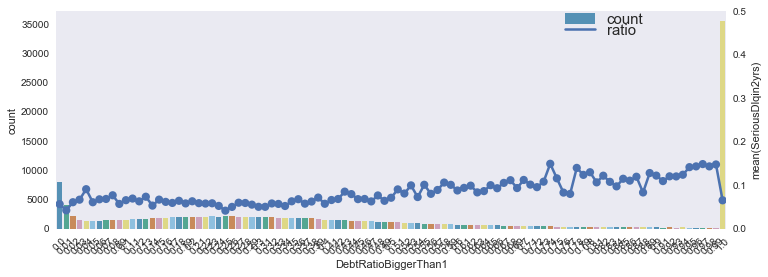

In [44]:
combined['DebtRatioBiggerThan1'] = combined['DebtRatio'].map(lambda x: np.round(x, 2) if x < 1 else 1)
show_count_ratio(combined[:train.shape[0]], 'DebtRatioBiggerThan1', 'SeriousDlqin2yrs', 12, 4, 0.5)

In [60]:
combined['MonthlyIncome'].describe()

count    2.016690e+05
mean     6.744818e+03
std      2.571761e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.212000e+03
max      7.727000e+06
Name: MonthlyIncome, dtype: float64

In [68]:
combined['NumberOfDependents'].fillna(0, inplace=True)
combined['MonthlyIncome'].fillna(combined['MonthlyIncome'].median(), inplace=True)
combined['MonthlyIncome'] = combined['MonthlyIncome'].map(lambda x: 100000.0 if x >= 10000.0 else x)
combined['IncomPer'] = combined['MonthlyIncome'] / (combined['NumberOfDependents']+1)

In [69]:
combined['IncomPer'].describe()

count    251503.000000
mean      11583.082501
std       23317.685696
min           0.000000
25%        2166.000000
50%        4290.000000
75%        5616.000000
max      100000.000000
Name: IncomPer, dtype: float64

In [95]:
combined[:train.shape[0]].groupby('IncomPer').agg({
    'SeriousDlqin2yrs': lambda x: x.mean(),
    'SeriousDlqin2yrs': lambda x: ,
})

,SeriousDlqin2yrs
IncomPer,
0.000000,"[0.04039167686658507, 66.0]"
0.166667,"[0.0, 0.0]"
0.200000,"[0.0, 0.0]"
0.250000,"[0.05084745762711865, 3.0]"
0.333333,"[0.03278688524590164, 4.0]"
0.500000,"[0.05970149253731343, 4.0]"
0.666667,"[0.0, 0.0]"
1.000000,"[0.017699115044247787, 6.0]"
2.000000,"[0.25, 1.0]"


In [98]:
combined[:train.shape[0]].groupby('IncomPer')['SeriousDlqin2yrs'].agg([np.mean,len])

,mean,len
IncomPer,,
0.000000,0.040392,1634.0
0.166667,0.000000,4.0
0.200000,0.000000,15.0
0.250000,0.050847,59.0
0.333333,0.032787,122.0
0.500000,0.059701,67.0
0.666667,0.000000,2.0
1.000000,0.017699,339.0
2.000000,0.250000,4.0


In [79]:
combined[combined['IncomPer']==6000].mean()

Unnamed: 0                              64615.859691
SeriousDlqin2yrs                            0.056530
RevolvingUtilizationOfUnsecuredLines        1.798767
age                                        55.354935
NumberOfTime30-59DaysPastDueNotWorse        0.221165
DebtRatio                                   0.330777
MonthlyIncome                            6000.000000
NumberOfOpenCreditLinesAndLoans             9.056480
NumberOfTimes90DaysLate                     0.061831
NumberRealEstateLoansOrLines                0.983353
NumberOfTime60-89DaysPastDueNotWorse        0.055886
NumberOfDependents                          0.000000
RUOL_P1                                     0.251992
ageNew                                     55.347206
ageLevel                                    2.116528
HasDue30_50                                 0.134958
HasDue60_89                                 0.045779
DebtRatioBiggerThan1                        0.294780
IncomPer                                 6000.

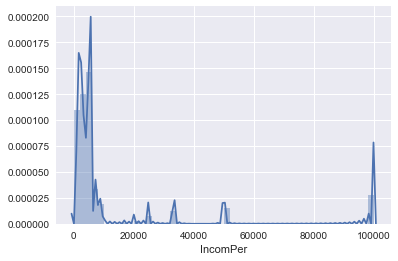

In [99]:
sns.distplot(combined['IncomPer'])

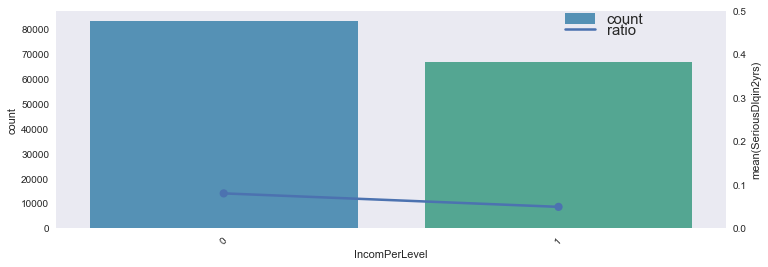

In [102]:
combined['IncomPerLevel'] = combined['IncomPer'].map(lambda x: 1 if x>5000 else 0)
show_count_ratio(combined[:train.shape[0]], 'IncomPerLevel', 'SeriousDlqin2yrs', 12, 4, 0.5)

In [109]:
combined['IncomPerLog'] = combined['IncomPer'].map(lambda x: np.log(x) if x > 0 else np.log(0.1))

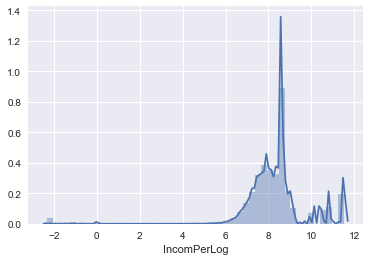

In [110]:
sns.distplot(combined['IncomPerLog'])

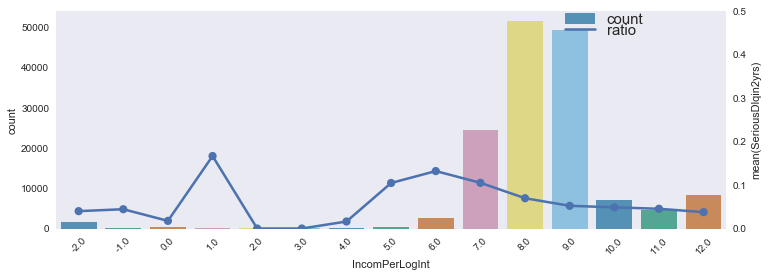

In [113]:
combined['IncomPerLogInt'] = combined['IncomPerLog'].map(lambda x: np.round(x, 0))
show_count_ratio(combined[:train.shape[0]], 'IncomPerLogInt', 'SeriousDlqin2yrs', 12, 4, 0.5)

In [114]:
combined['NumberOfOpenCreditLinesAndLoans'].describe()

count    251503.000000
mean          8.453064
std           5.145194
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          85.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

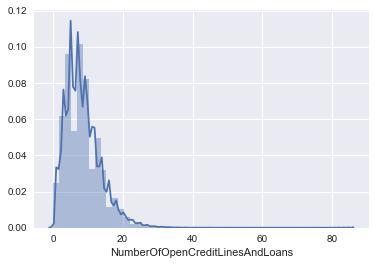

In [117]:
sns.distplot(combined['NumberOfOpenCreditLinesAndLoans'])

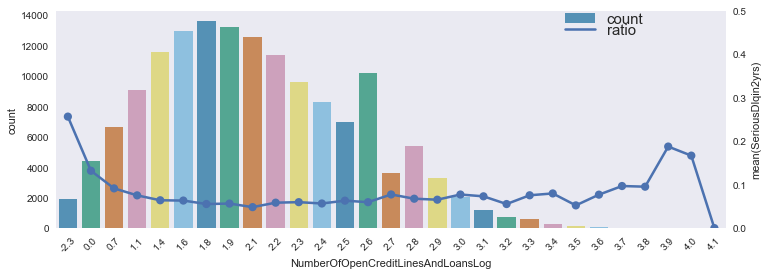

In [121]:
combined['NumberOfOpenCreditLinesAndLoansLog'] = combined['NumberOfOpenCreditLinesAndLoans'].map(lambda x: np.round(np.log(x),1) if x>0 else np.round(np.log(0.1),1))
show_count_ratio(combined[:train.shape[0]], 'NumberOfOpenCreditLinesAndLoansLog', 'SeriousDlqin2yrs', 12, 4, 0.5)

In [122]:
combined['NumberRealEstateLoansOrLines'].describe()

count    251503.000000
mean          1.016155
std           1.121935
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

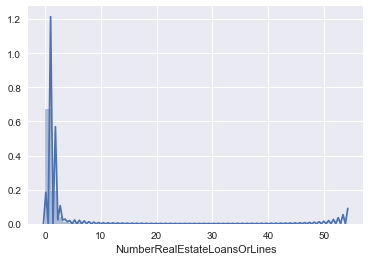

In [123]:
sns.distplot(combined['NumberRealEstateLoansOrLines'])

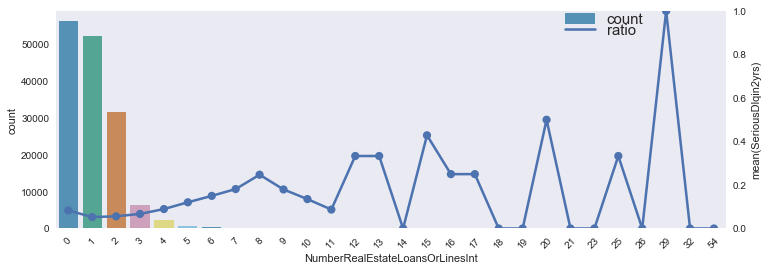

In [125]:
combined['NumberRealEstateLoansOrLinesInt'] = combined['NumberRealEstateLoansOrLines'].map(lambda x: np.round(x, 0))
show_count_ratio(combined[:train.shape[0]], 'NumberRealEstateLoansOrLinesInt', 'SeriousDlqin2yrs', 12, 4, 1.0)

In [3]:
combined = pd.concat([train, test], axis=0, ignore_index=True)

In [4]:
combined['UnknownNumberOfDependents'] = combined['NumberOfDependents'].isnull().astype(int)
combined['UnknownMonthlyIncome'] = combined['MonthlyIncome'].isnull().astype(int)
combined['NoDependents'] = combined['NumberOfDependents'] == 0

In [5]:
combined.loc[combined['UnknownNumberOfDependents']==1, 'NumberOfDependents'] = 0

In [6]:
combined['NoIncome'] = combined['MonthlyIncome'] == 0
combined.loc[combined['NoIncome'].isnull(), 'NoIncome'] = 0

In [7]:
combined.loc[combined['UnknownMonthlyIncome']==1, 'MonthlyIncome'] = 0

In [8]:
combined['ZeroDebtRatio'] = (combined['DebtRatio'] == 0).astype(int)

In [9]:
combined['UnknownIncomeDebtRatio'] = combined['DebtRatio']
combined.loc[combined['UnknownMonthlyIncome']==0, 'UnknownIncomeDebtRatio'] = 0

In [10]:
combined['WeirdRevolvingUtilization'] = combined['RevolvingUtilizationOfUnsecuredLines']
combined.loc[np.log(combined['RevolvingUtilizationOfUnsecuredLines'])<=3, 'WeirdRevolvingUtilization'] = 0
combined['ZeroRevolvingUtilization'] = (combined['RevolvingUtilizationOfUnsecuredLines'] == 0).astype(int)
combined.loc[np.log(combined['RevolvingUtilizationOfUnsecuredLines'])>3, 'RevolvingUtilizationOfUnsecuredLines'] = 0

E:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
E:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [11]:
combined['Log.Debt']=np.log(combined['MonthlyIncome'].map(lambda x: 1 if x <= 1 else x) * combined['DebtRatio'])
combined.loc[np.isinf(combined['Log.Debt']), 'Log.Debt'] = 0

E:\software\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [12]:
combined['RevolvingLines'] = combined['NumberOfOpenCreditLinesAndLoans'] - combined['NumberRealEstateLoansOrLines']

In [13]:
combined['HasRevolvingLines'] = (combined['RevolvingLines'] > 0).astype(int)
combined['HasRealEstateLoans'] = (combined['NumberRealEstateLoansOrLines'] > 0).astype(int)
combined['HasMultipleRealEstateLoans'] = (combined['NumberOfOpenCreditLinesAndLoans']>2).astype(int)

In [14]:
combined['EligibleSS'] = (combined['age']>=60).astype(int)
combined['DTIOver33'] = ((combined['NoIncome']==0) & (combined['DebtRatio']>0.33)).astype(int)
combined['DTIOver43'] = ((combined['NoIncome']==0) & (combined['DebtRatio']>0.43)).astype(int)
combined['DisposableIncome'] = (1 - combined['DebtRatio']) * combined['MonthlyIncome']
combined.loc[combined['NoIncome']==1, 'DisposableIncome'] = 0

In [15]:
combined['RevolvingToRealEstate'] = combined['RevolvingLines'] / (1 + combined['NumberRealEstateLoansOrLines'])

In [18]:
combined['NumberOfTime30-59DaysPastDueNotWorseLarge'] = (combined['NumberOfTime30-59DaysPastDueNotWorse']>90).astype(int)
combined['NumberOfTime30-59DaysPastDueNotWorse96'] = (combined['NumberOfTime30-59DaysPastDueNotWorse']==96).astype(int)
combined['NumberOfTime30-59DaysPastDueNotWorse98'] = (combined['NumberOfTime30-59DaysPastDueNotWorse']==98).astype(int)
combined['Never60-89DaysPastDueNotWorse'] = (combined['NumberOfTime30-59DaysPastDueNotWorse']==0).astype(int)
combined.loc[combined['NumberOfTime30-59DaysPastDueNotWorse']>90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 0

In [22]:
combined['NumberOfTime60-89DaysPastDueNotWorseLarge'] = (combined['NumberOfTime60-89DaysPastDueNotWorse']>90).astype(int)
combined['NumberOfTime60-89DaysPastDueNotWorse96'] = (combined['NumberOfTime60-89DaysPastDueNotWorse']==96).astype(int)
combined['NumberOfTime60-89DaysPastDueNotWorse98'] = (combined['NumberOfTime60-89DaysPastDueNotWorse']==98).astype(int)
combined['Never60-89DaysPastDueNotWorse'] = (combined['NumberOfTime60-89DaysPastDueNotWorse']==0).astype(int)
combined.loc[combined['NumberOfTime60-89DaysPastDueNotWorse']>90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 0